### Visualizing Monthly Composites

This notebook shows how to aggregate a time-series of satellite imagery to monthly median composites and visualize them in a grid.

#### Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install pystac-client odc-stac rioxarray dask

In [ ]:
import os
import matplotlib.pyplot as plt
import pystac_client
from odc.stac import stac_load
import xarray as xr
import rioxarray as rxr

In [ ]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

#### Get Satellite Imagery using STAC API

We define a location and time of interest to get some satellite imagery.

In [ ]:
latitude = 27.163
longitude = 82.608
year = 2023

Let's use Element84 search endpoint to look for items from the sentinel-2-l2a collection on AWS.

In [ ]:
catalog = pystac_client.Client.open(
    'https://earth-search.aws.element84.com/v1')

# Define a small bounding box around the chosen point
km2deg = 1.0 / 111
x, y = (longitude, latitude)
r = 1 * km2deg  # radius in degrees
bbox = (x - r, y - r, x + r, y + r)

search = catalog.search(
    collections=['sentinel-2-c1-l2a'],
    bbox=bbox,
    datetime=f'{year}',
    query={'eo:cloud_cover': {'lt': 30}},
)
items = search.item_collection()

Load the matching images as a XArray Dataset.

In [ ]:
ds = stac_load(
    items,
    bands=['red', 'green', 'blue', 'nir'],
    resolution=10,
    bbox=bbox,
    chunks={},  # <-- use Dask
    groupby='solar_day',
)
ds

<xarray.Dataset>
Dimensions:      (y: 202, x: 182, time: 70)
Coordinates:
  * y            (y) float64 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 32644
  * time         (time) datetime64[ns] 2023-01-13T05:21:06.880000 ... 2023-12...
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 202, 182), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 202, 182), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 202, 182), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 202, 182), meta=np.ndarray>

In [ ]:
%%time
ds = ds.compute()

CPU times: user 12.3 s, sys: 24.4 s, total: 36.7 s
Wall time: 1min 31s


#### Visualizing Monthly Composites

Aggregate it to a monthly median composites `groupby()` method.

In [ ]:
monthly = ds.groupby('time.month').median(dim='time')
monthly

<xarray.Dataset>
Dimensions:      (y: 202, x: 182, month: 12)
Coordinates:
  * y            (y) float64 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 32644
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    red          (month, y, x) float64 1.786e+03 1.72e+03 ... 2.225e+03
    green        (month, y, x) float64 2.006e+03 1.976e+03 ... 2.191e+03
    blue         (month, y, x) float64 1.842e+03 1.802e+03 ... 2.016e+03
    nir          (month, y, x) float64 3.754e+03 3.972e+03 ... 3.232e+03

Using monthly_da to display composites for all months.

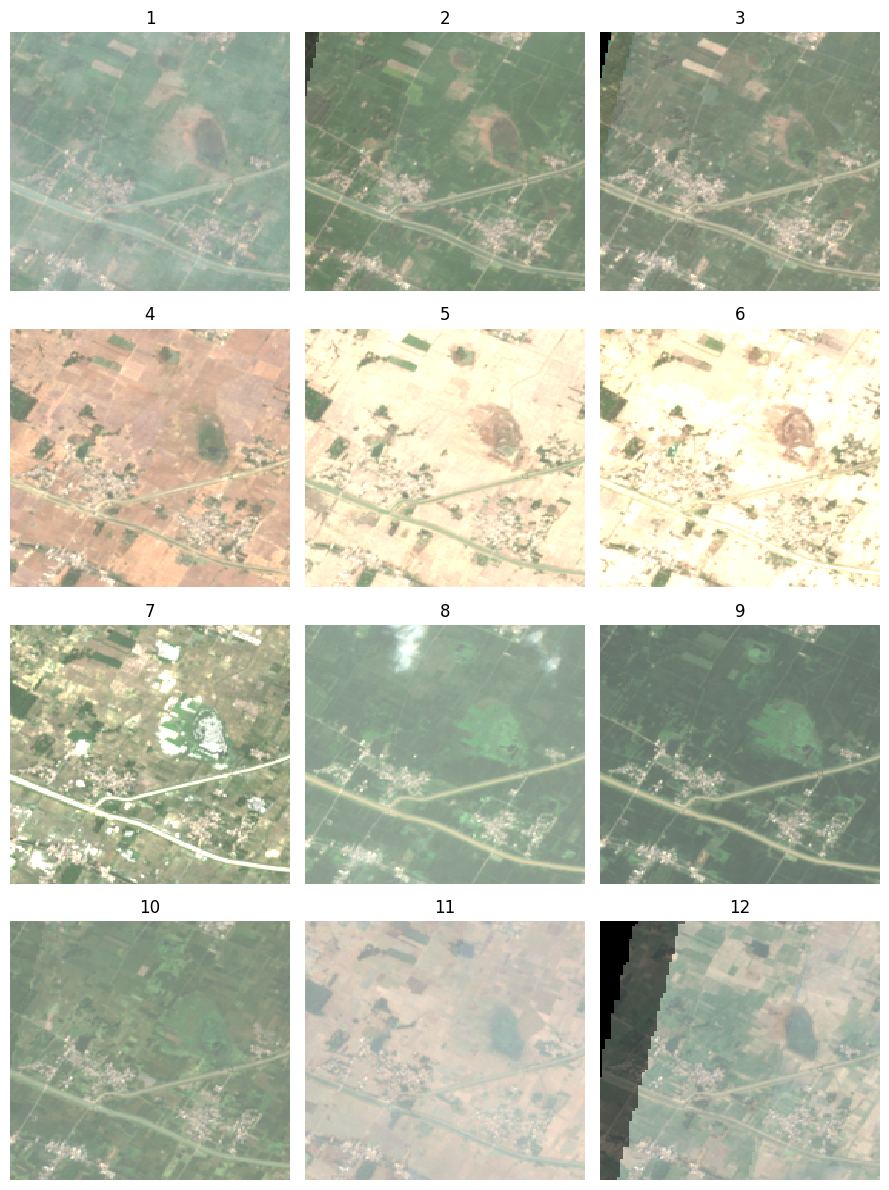

In [ ]:
monthly_da = monthly.to_array('band')
fig, axes = plt.subplots(4, 3)
fig.set_size_inches(9, 12)
for index, ax in enumerate(axes.flat):
    month_da = monthly_da.isel(month=index)
    month_da.sel(band=['red', 'green', 'blue']).plot.imshow(
      ax=ax,
      vmin=0,
      vmax=3000)
    ax.set_title(f'{month_da.month.values}')
    ax.set_axis_off()
plt.tight_layout()
plt.show()